In [157]:
import MySQLdb
import sshtunnel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from ast import literal_eval
import matplotlib.pyplot as plt
import glob
from pathlib import Path
import utils
from params import phase_2_statements
from tabulate import tabulate
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

temp_datetime = utils.get_datetime_str()

In [158]:
sshtunnel.SSH_TIMEOUT = 5.0
sshtunnel.TUNNEL_TIMEOUT = 5.0

with sshtunnel.SSHTunnelForwarder(
    ('ssh.pythonanywhere.com'),
    ssh_username='Grawi', ssh_password='midgeq-xikFah-gukpu7',
    remote_bind_address=('Grawi.mysql.pythonanywhere-services.com', 3306)
) as tunnel:
    print("Successfully connected to Pythonanywhere")
    connection = MySQLdb.connect(
        user='Grawi',
        passwd='david2202087',
        host='127.0.0.1', port=tunnel.local_bind_port,
        db='Grawi$Interactive_quiz_database',
    )
    # Do stuff
    print("Successfully connected to database")
    
    try:
        cursor = connection.cursor()
        query = "SELECT * FROM pilot_2 where submit_time>='2024-01-01';"
        df = pd.read_sql(query, connection)
        print(f"Data read finished, length {len(df)}")
    except Exception as e:
        print("Error:", e)
    
    finally:
        # Close the cursor and connection
        cursor.close()
        connection.close()

df["pilot_2_answers"] = df["pilot_2_answers"].map(literal_eval)
df['submit_time'] = pd.to_datetime(df['submit_time'])
df = df.loc[df["participantId"] != "testId"]
df.head()

Successfully connected to Pythonanywhere
Successfully connected to database
Data read finished, length 40


,participantId,assignmentId,projectId,attention_passed,total_time,pilot_2_answers,ideology_label,bot_detected,submit_time,identity_choices,ideologies,reason
0,01D7025D80B743ABA0E82D976A3742B1,50ae4605-7043-4184-a345-b8312d6fa14a,7cc7f6f8-ec89-4df4-b229-6ca392644915,1,376.230,"[{'answer': -1, 'idx_of_question': 5}, {'answe...",-1.0,None,2024-01-09 07:42:02,None,None,None
1,0ED83422D6474D4FB61C995A7C79559B,fcf287ab-ec55-48ac-911f-c01a8230e3a2,7cc7f6f8-ec89-4df4-b229-6ca392644915,1,289.569,"[{'answer': 1.1, 'idx_of_question': 7}, {'answ...",-2.0,None,2024-01-14 05:53:35,None,None,None
2,0F8F309B96464B85B860E8D4F8F32BF8,b80c01df-0ce7-49dd-b02c-a0ee424faf55,7cc7f6f8-ec89-4df4-b229-6ca392644915,1,152.227,"[{'answer': -1.4, 'idx_of_question': 5}, {'ans...",0.1,None,2024-01-14 05:52:59,None,None,None
3,204AEB81228D4911B19E71F42197FEAF,4099048d-b9ea-4157-9da2-ee2b39cc39d3,7cc7f6f8-ec89-4df4-b229-6ca392644915,1,137.327,"[{'answer': -0.9, 'idx_of_question': 7}, {'ans...",1.4,None,2024-01-14 05:59:35,None,None,None
4,23EB7891621447268A92919CB45C6991,7725ebf0-c8e9-42ac-8152-5adac6dc50f1,7cc7f6f8-ec89-4df4-b229-6ca392644915,1,131.702,"[{'answer': 2.2, 'idx_of_question': 6}, {'answ...",1.6,None,2024-01-09 07:41:49,None,None,None


In [159]:
df["ideology_label"] = df.apply(lambda row: row["ideology_label"] if row["submit_time"] >= pd.to_datetime("2024-01-09") else row["ideology_label"] - 2, axis=1)

ids_attention_failed = df.loc[df['attention_passed'] == 0]["participantId"].tolist()
print(f"Participants who failed attention check: {ids_attention_failed}")
df = df.loc[:, ["participantId", "pilot_2_answers", "ideology_label"]].set_index("participantId")

def IdeologyToNumber(ideology):
    if ideology == "Moderate":
        return 0
    elif ideology == "Somewhat Conservative":
        return 1
    elif ideology == "Conservative":
        return 2
    elif ideology == "Somewhat Liberal": 
        return -1
    elif ideology == "Liberal":
        return -2

connect_data_csv = glob.glob('data/connect_raw_data/pilot_2_2*.csv')[0]
df_connect = pd.read_csv(connect_data_csv).set_index("ParticipantId")
df["connect_ideology"] = df_connect["Political Ideology"].map(IdeologyToNumber)
print("rmse of ideology:", np.sqrt(np.mean((df["ideology_label"] - df["connect_ideology"])**2)))
df["ideology"] = df["ideology_label"]
df.drop(["connect_ideology", "ideology_label"], axis=1, inplace=True)
df.head()

Participants who failed attention check: []
rmse of ideology: 0.8804828220925153


,pilot_2_answers,ideology
participantId,,
01D7025D80B743ABA0E82D976A3742B1,"[{'answer': -1, 'idx_of_question': 5}, {'answe...",-1.0
0ED83422D6474D4FB61C995A7C79559B,"[{'answer': 1.1, 'idx_of_question': 7}, {'answ...",-2.0
0F8F309B96464B85B860E8D4F8F32BF8,"[{'answer': -1.4, 'idx_of_question': 5}, {'ans...",0.1
204AEB81228D4911B19E71F42197FEAF,"[{'answer': -0.9, 'idx_of_question': 7}, {'ans...",1.4
23EB7891621447268A92919CB45C6991,"[{'answer': 2.2, 'idx_of_question': 6}, {'answ...",1.6


### 1. The Answer Patter for Each Question

In [160]:
def IndexToType(index):
    if index >= 0 and index <= 3:
        return "prediction"
    elif index >= 4 and index <= 7:
        return "issue"
    elif index == 8 or index == 9:
        return "fact"

answers = {"index": [], "seq": [], "answer": [], "ideology": []}
for id, row in df.iterrows():
    pilot_2_answers = row["pilot_2_answers"]
    ideology = row["ideology"]
    tmp_seq = {"prediction": 0, "issue": 0, "fact": 0}
    for each_answer in pilot_2_answers:
        question_type = IndexToType(each_answer["idx_of_question"])
        answers["index"].append(each_answer["idx_of_question"])
        for type_question in phase_2_statements[question_type]:
            if type_question["index"] == each_answer["idx_of_question"]:
                if "alignment" in type_question and type_question["alignment"] == 0 or "alignment" not in type_question:
                    answers["answer"].append(each_answer["answer"])
                else:
                    answers["answer"].append(-each_answer["answer"])
                break
        answers["ideology"].append(ideology)
        answers["seq"].append(tmp_seq[question_type])
        tmp_seq[question_type] += 1
    
df_answers = pd.DataFrame(answers)
df_answers.head()

,index,seq,answer,ideology
0,5,0,1.0,-1.0
1,3,0,1.0,-1.0
2,7,1,-2.1,-1.0
3,2,1,-1.9,-1.0
4,4,2,-1.9,-1.0


#### 1.1 Distribution graph

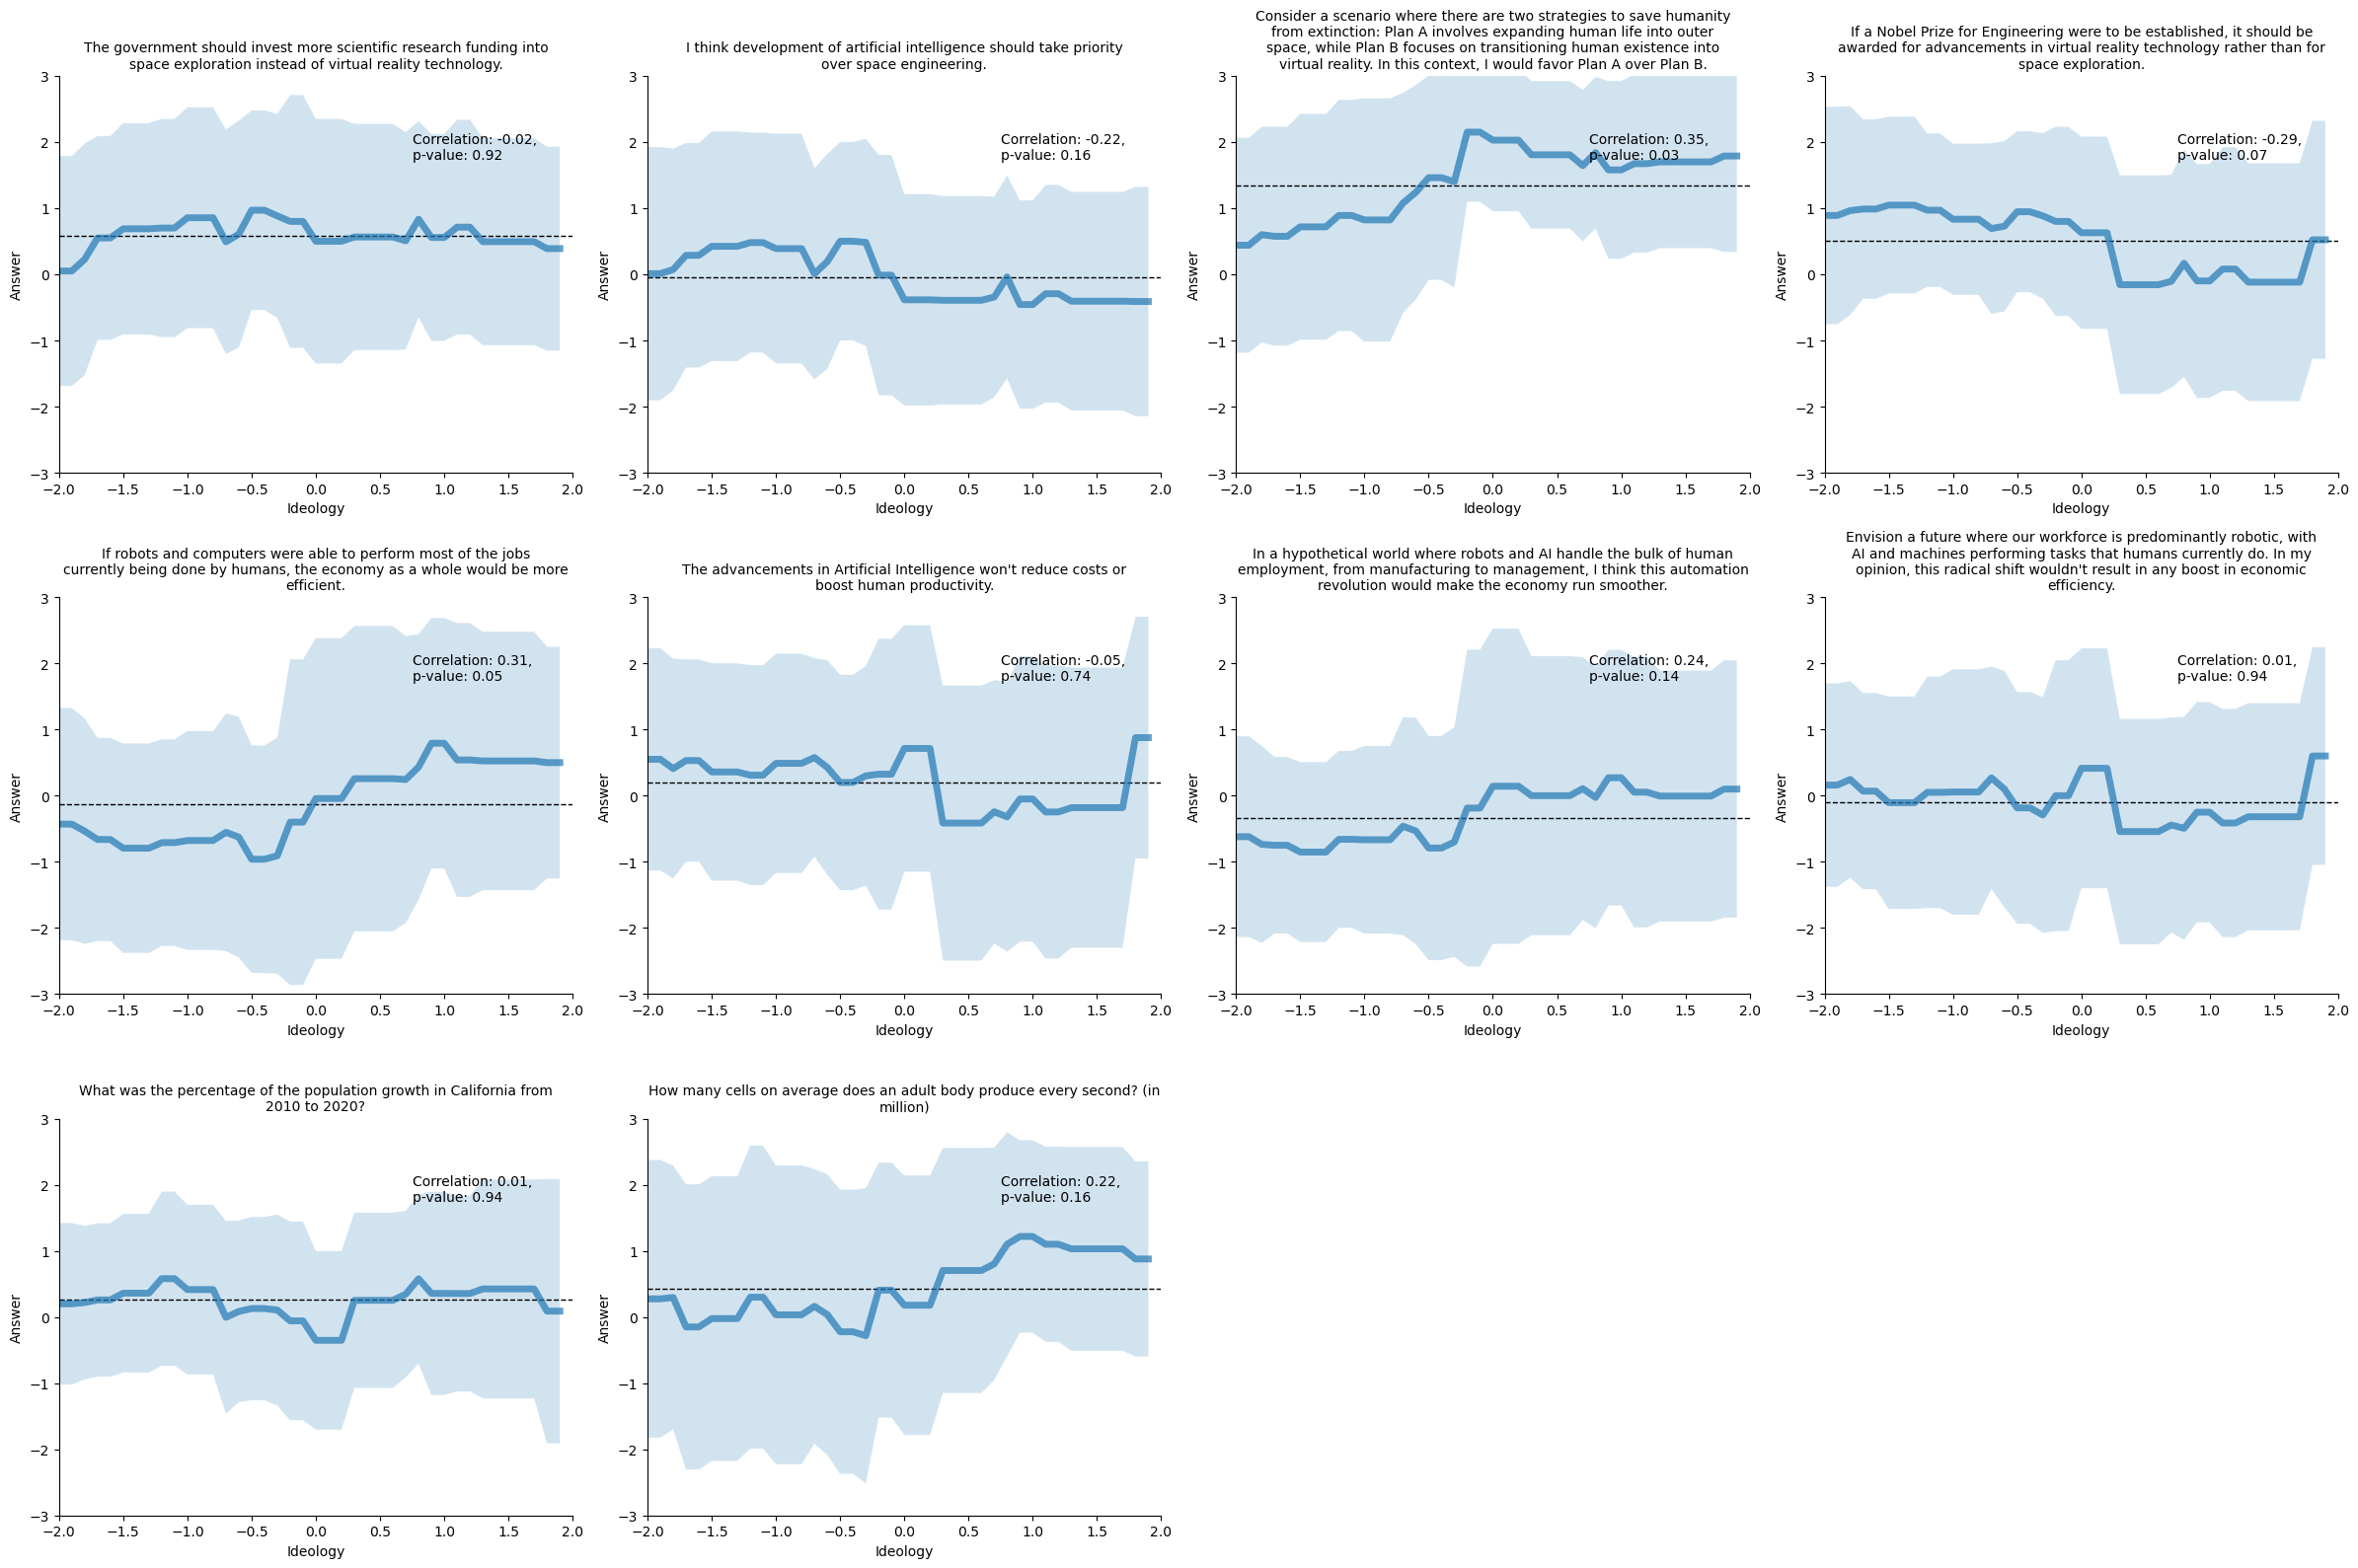

In [161]:
import textwrap

# 画图
fig, axes = plt.subplots(3, 4, figsize=(24, 16))

axes[2, 2].axis("off")
axes[2, 3].axis("off")

for index in range(10):
    ax = axes[index // 4][index % 4]
    ax.set(
        ylim=(-3, 3),
        xlim=(-2, 2),
        xlabel="Ideology",
        ylabel="Answer",
    )
    for type_question in phase_2_statements[IndexToType(index)]:
        if type_question["index"] == index:
            title = textwrap.fill(type_question["text"], 70)
            ax.set_title(title, fontsize=10)
            break
    x = df_answers.loc[df_answers["index"] == index]["ideology"]
    y = df_answers.loc[df_answers["index"] == index]["answer"]
    answer_avg = y.mean()
    ax.axhline(answer_avg, color="black", linestyle="--", linewidth=1)
    correlation = pearsonr(x, y)[0], pearsonr(x, y)[1]
    ax.text(0.75, 1.75, f"Correlation: {correlation[0]:.2f}, \np-value: {correlation[1]:.2f}", fontsize=10)
    average, low, high = utils.sliding_average(x, y)
    utils.plot_with_std(ax, average, low, high)

utils.savefig(fig, f"visualization/{temp_datetime}-pilot_2-questions.pdf")

#### 1.2 Correlation with ideology

In [162]:
# 和意识形态绝对值的相关系数
df_answers.groupby("index").apply(lambda x: pearsonr(x["answer"], abs(x["ideology"]))[0])

index
0   -0.046560
1    0.013494
2   -0.187934
3    0.084203
4   -0.000418
5    0.071133
6   -0.084185
7    0.040740
8    0.080893
9   -0.018964
dtype: float64

### 2. Relationship Between Questions

#### 2.1 Correlation of answers for each pair of questions

In [163]:
def CalCorrelation(ind_1, ind_2):
    df_1 = df_answers.loc[df_answers["index"] == ind_1]
    df_2 = df_answers.loc[df_answers["index"] == ind_2]
    result = pearsonr(df_1["answer"], df_2["answer"])
    return result[0]

for question_type in ["prediction", "issue"]:
    print("\n" + question_type + ":\n")
    row_labels = ["A1", "A2", "A3", "A4"]
    col_labels = ["A1", "A2", "A3", "A4"]
    table_data = []
    for row_idx, row_label in enumerate(row_labels):
        row_data = []
        for col_idx, col_label in enumerate(col_labels):
            if row_idx == col_idx:
                row_data.append(None)
            else:
                value = 0
                if question_type == "prediction":
                    row_data.append(CalCorrelation(row_idx, col_idx))
                elif question_type == "issue":
                    row_data.append(CalCorrelation(row_idx + 4, col_idx + 4))
        table_data.append(row_data)
    table = tabulate(table_data, headers=col_labels, showindex=row_labels, tablefmt='markdown', floatfmt=".2f")
    print(table)


prediction:

      A1    A2    A3    A4
--  ----  ----  ----  ----
A1        0.53  0.44  0.60
A2  0.53        0.29  0.81
A3  0.44  0.29        0.31
A4  0.60  0.81  0.31

issue:

      A1    A2    A3    A4
--  ----  ----  ----  ----
A1        0.47  0.85  0.49
A2  0.47        0.50  0.81
A3  0.85  0.50        0.49
A4  0.49  0.81  0.49


#### 2.2 Scatter plots of answers for each pair of questions (with/ without rescaling)

In [164]:
df_scale = df_answers.groupby("index")["answer"].agg(["max", "min"])
df_answers["answer_rescaled"] = df_answers.apply(lambda row: ((row["answer"] - df_scale.loc[row["index"]]["min"]) / (df_scale.loc[row["index"]]["max"] - df_scale.loc[row["index"]]["min"]) - 0.5) * 6, axis=1)

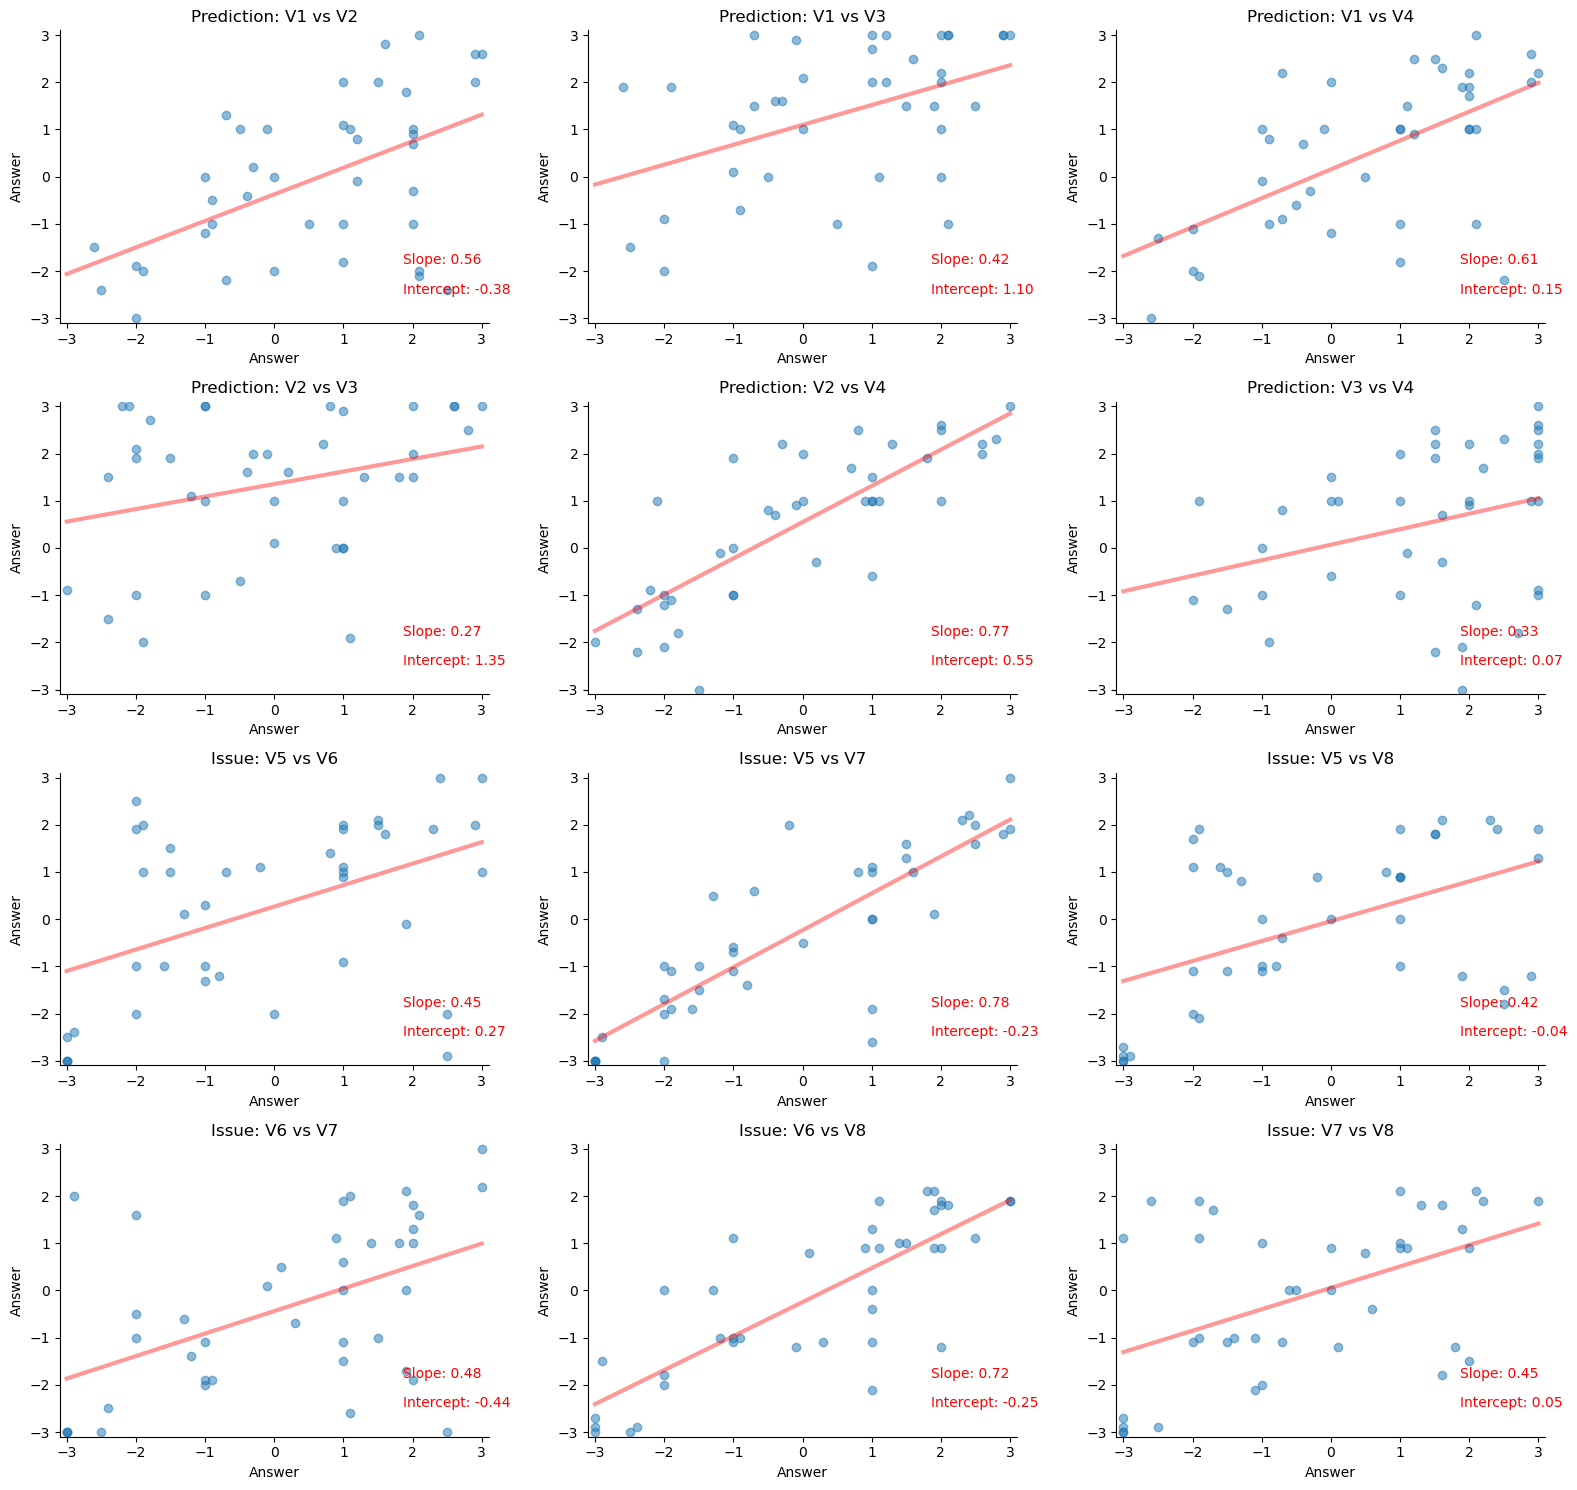

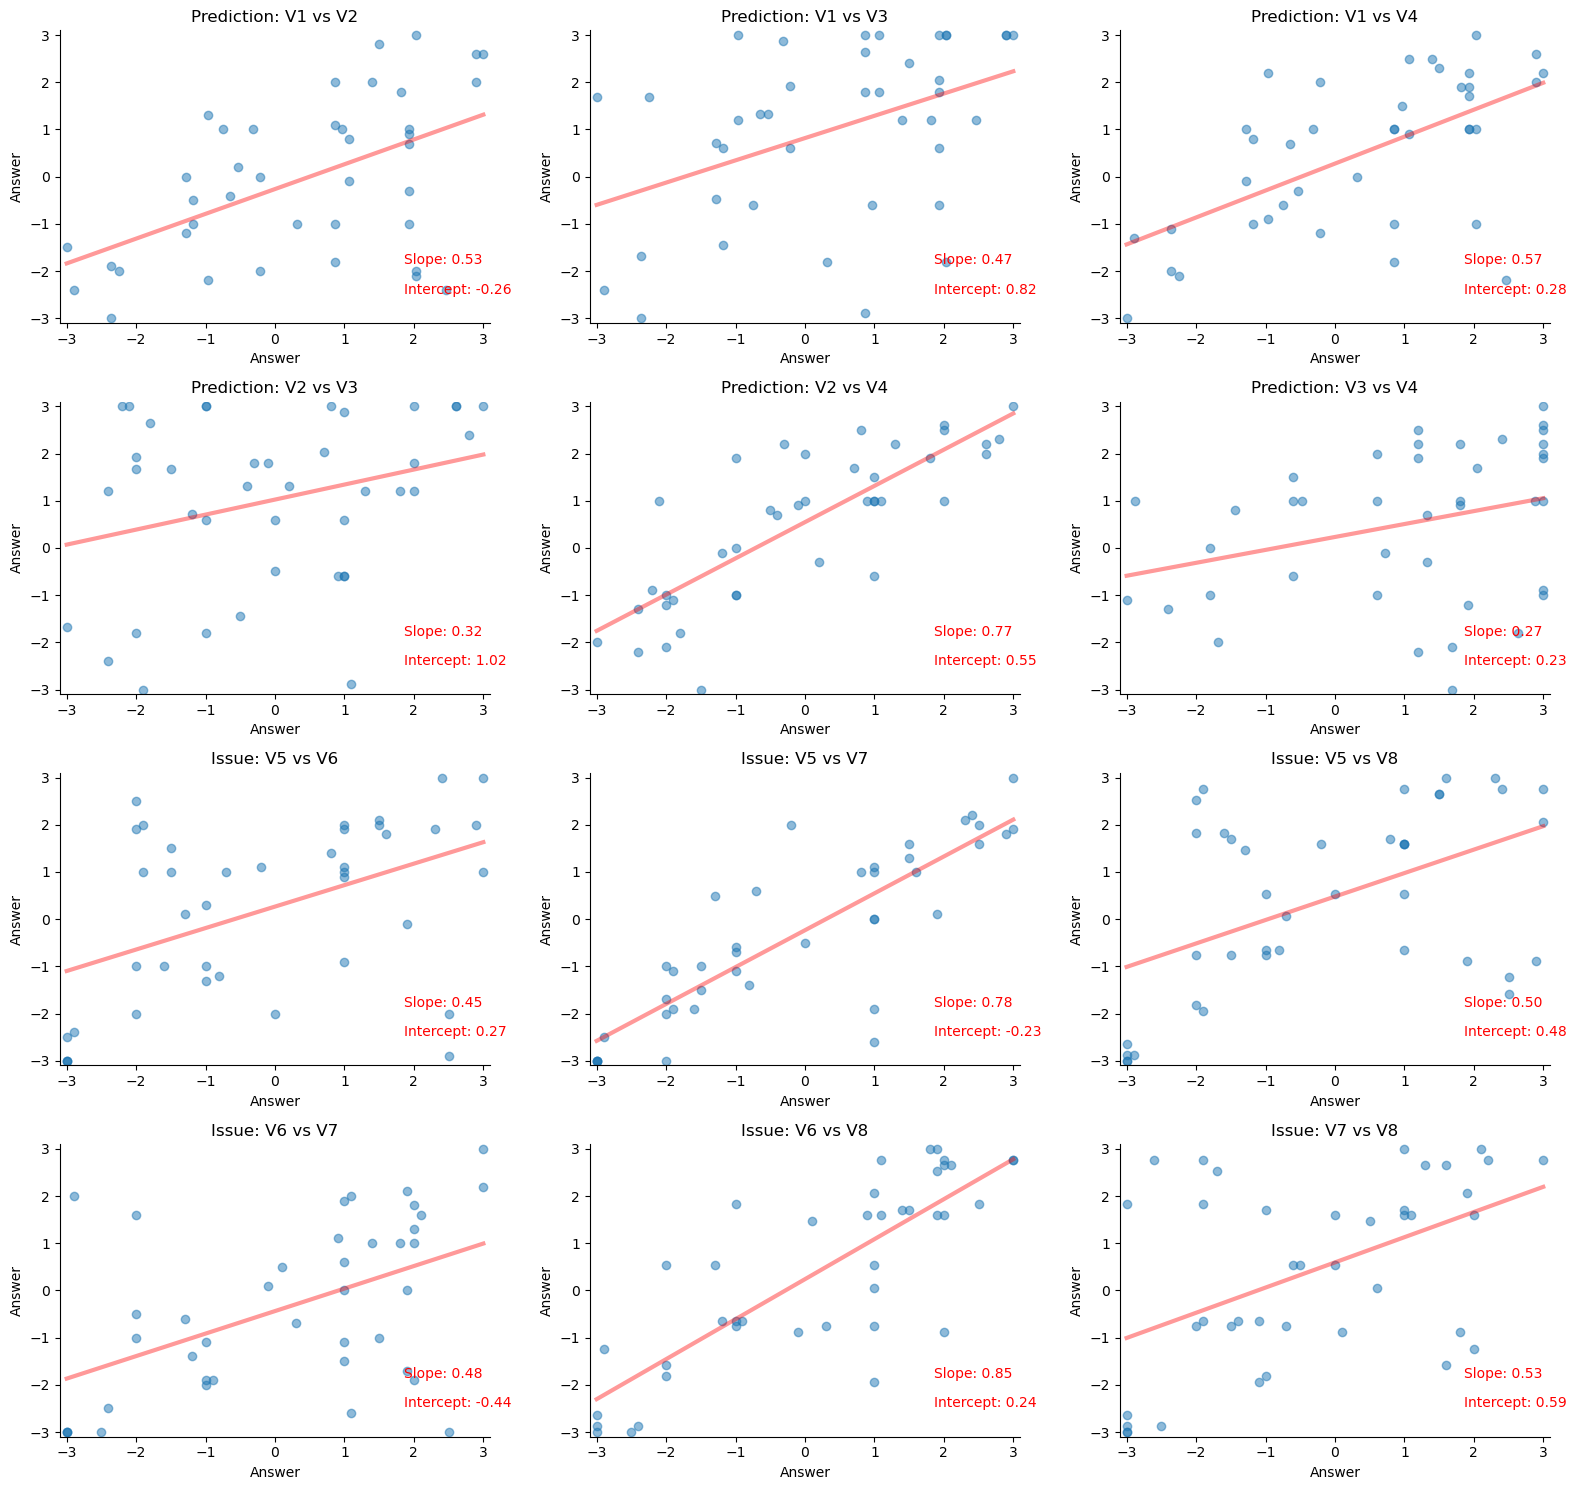

In [165]:
figure_size = (4, 5)

for rescale in [False, True]:

    fig, axes = plt.subplots(4, 3, figsize=(figure_size[0] * 4, figure_size[1] * 3))
    fig_idx = 0
    target_col = "answer_rescaled" if rescale else "answer"

    for question_type in ["prediction", "issue"]:
        for ind_1 in range(4):
            for ind_2 in range(ind_1 + 1, 4):
                ax = axes[fig_idx // 3][fig_idx % 3]
                ax.set(
                    ylim=(-3.1, 3.1),
                    xlim=(-3.1, 3.1),
                    xlabel="Answer",
                    ylabel="Answer",
                )
                x = None
                y = None
                if question_type == "prediction":
                    ax.set_title(f"Prediction: V{ind_1 + 1} vs V{ind_2 + 1}")
                    x = df_answers.loc[df_answers["index"] == ind_1][target_col]
                    y = df_answers.loc[df_answers["index"] == ind_2][target_col]
                elif question_type == "issue":
                    ax.set_title(f"Issue: V{ind_1 + 5} vs V{ind_2 + 5}")
                    x = df_answers.loc[df_answers["index"] == ind_1 + 4][target_col]
                    y = df_answers.loc[df_answers["index"] == ind_2 + 4][target_col]
                ax.scatter(x, y, alpha=0.5)

                # Calculate regression line parameters
                slope, intercept = np.polyfit(x, y, 1)
                regression_x = np.array([-3, 3])
                regression_line = slope * regression_x + intercept

                # Plot regression line
                ax.plot(regression_x, regression_line, color='red', alpha=0.4, linewidth=3)

                # Label the parameters of the line
                ax.text(0.8, 0.2, f"Slope: {slope:.2f}", transform=ax.transAxes, color='red')
                ax.text(0.8, 0.1, f"Intercept: {intercept:.2f}", transform=ax.transAxes, color='red')

                fig_idx += 1

    # Save the figure with higher resolution
    utils.savefig(fig, f"test_{rescale}.jpg", dpi=600)

#### 2.3 PCA selection (with/ without rescaling)

In [166]:
for rescale in [False, True]:
    if rescale:
        print("\nRescaled: ")
    else:
        print("Not Rescaled: ")
    for question_type in ["prediction", "issue"]:
        M = np.zeros((len(df), 4), dtype=float)
        for index, (id, row) in enumerate(df.iterrows()):
            pilot_2_answers = row["pilot_2_answers"]
            for each_answer in pilot_2_answers:
                if question_type == "prediction":
                    if each_answer["idx_of_question"] < 4:
                        M[index][each_answer["idx_of_question"]] = each_answer["answer"]
                else:
                    if each_answer["idx_of_question"] >= 4 and each_answer["idx_of_question"] < 8:
                        M[index][each_answer["idx_of_question"] - 4] = each_answer["answer"]
        if rescale:
            scaler = MinMaxScaler(feature_range=(-3, 3))
            M = scaler.fit_transform(M)
        pca = PCA(n_components=1)
        pca.fit(M)
        M_pca = pca.transform(M)
        print("    ", question_type, pca.explained_variance_ratio_)

Not Rescaled: 
     prediction [0.64]
     issue [0.7]

Rescaled: 
     prediction [0.62]
     issue [0.7]


### 2. The Impact of Order for A Question

In [167]:
df_no_fact = df_answers.loc[df_answers["index"] <= 7]
pearsonr(df_no_fact["answer"], df_no_fact["seq"])

PearsonRResult(statistic=0.07173566056401265, pvalue=0.20058936150876444)

In [168]:
df_answers.groupby(["index", "seq"])["answer"].mean()

index  seq
0      0     -0.520000
       1      0.938462
       2      0.293333
       3      1.300000
1      0      0.088889
       1     -0.787500
       2      1.400000
       3     -0.194444
2      0      0.938462
       1      1.661538
       2      1.400000
       3      1.422222
3      0      0.192308
       1      0.183333
       2      0.526667
       3      1.466667
4      0     -1.400000
       1     -0.125000
       2     -0.053333
       3      1.966667
5      0      0.514286
       1      0.491667
       2     -0.437500
       3      0.169231
6      0      0.080000
       1     -0.200000
       2     -0.477778
       3     -0.691667
7      0     -0.341667
       1     -0.127273
       2      0.400000
       3     -0.188889
8      0      0.261667
9      1      0.433750
Name: answer, dtype: float64